### TopK Sparse Autoencoder for Protein-Ligand Docking Analysis

**Goal**: Train a TopK Sparse Autoencoder on 30D VAE latent vectors to identify interpretable features distinguishing native-like poses (RMSD <2Å) from poor poses (RMSD >2Å).

**Data**: ~6,000-7,000 poses per protein system, filtered to generations 0-7

In [16]:
# Imports and setup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from scipy.stats import spearmanr
from typing import Optional
import pickle
import glob
import os
from pathlib import Path

from schrodinger.structure import StructureReader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Matplotlib inline for Jupyter
%matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: NVIDIA RTX A4500


In [11]:
# Data Loading Section
# Load pickle files containing latent vectors and pose quality metrics
# Following the pattern from example.ipynb

def load_pickle_data(data_dir, max_gen=7):
    """
    Load latent vectors and metadata from pickle files.
    Follows the pattern from example.ipynb.
    
    Args:
        data_dir: Directory containing .pkl files (can include subdirectories)
        max_gen: Maximum generation number to include (default: 7)
    
    Returns:
        latents: numpy array of shape [N, 30] - latent vectors
        rmsd: numpy array of shape [N] - ligand RMSD values
        energy: numpy array of shape [N] - energy scores
        gen: numpy array of shape [N] - generation numbers
    """
    # Resolve absolute path
    data_dir = os.path.abspath(data_dir)
    print(f"Searching in: {data_dir}")
    print(f"Directory exists: {os.path.exists(data_dir)}")
    
    # Find all pickle files (recursively search subdirectories)
    pattern = os.path.join(data_dir, '**/*.pkl')
    pkl_files = sorted(glob.glob(pattern, recursive=True))
    if not pkl_files:
        # Fallback to non-recursive search
        pattern = os.path.join(data_dir, '*.pkl')
        pkl_files = sorted(glob.glob(pattern))
    print(f"Found {len(pkl_files)} pickle files")
    if len(pkl_files) == 0 and os.path.exists(data_dir):
        # Try to list what's actually in the directory
        try:
            contents = os.listdir(data_dir)
            pkl_in_dir = [f for f in contents if f.endswith('.pkl')]
            print(f"  Directory contains {len(contents)} items, {len(pkl_in_dir)} .pkl files directly")
        except:
            pass
    
    z_list, E_list, lr_list, gen_list = [], [], [], []
    
    for file in pkl_files:
        with open(file, 'rb') as f:
            ld = pickle.load(f)
        
        # Check for required keys (following example.ipynb pattern)
        if 'scores' not in ld:
            continue
        if 'site_rmsd' not in ld['scores']:
            continue
        if 'lig_rmsd' not in ld['scores']:
            continue
        if 'z' not in ld:
            continue
        
        # Filter by generation
        if ld.get('curr_gen', 0) > max_gen:
            continue
        
        z_list.append(ld['z'])
        E_list.append(ld['scores']['energy'])
        lr_list.append(ld['scores']['lig_rmsd'])
        gen_list.append(ld['curr_gen'])
    
    # Convert to numpy arrays (following example.ipynb but converting torch to numpy)
    if len(z_list) == 0:
        print("Warning: No valid data loaded")
        return np.array([]).reshape(0, 30), np.array([]), np.array([]), np.array([])
    
    # Stack latent vectors (handle both torch.Tensor and numpy arrays)
    if isinstance(z_list[0], torch.Tensor):
        latents = torch.stack(z_list).cpu().numpy()
    else:
        latents = np.stack([np.array(z) for z in z_list])
    
    # Ensure latents are 2D array [N, 30]
    if latents.ndim == 1:
        latents = latents.reshape(1, -1)
    elif latents.ndim > 2:
        latents = latents.reshape(len(z_list), -1)
    
    # Convert other lists to numpy arrays
    rmsd = np.array(lr_list)
    energy = np.array(E_list)
    gen = np.array(gen_list)
    
    print(f"\nLoaded {len(latents)} samples")
    print(f"Latent vectors shape: {latents.shape}")
    if len(rmsd) > 0:
        print(f"RMSD range: {rmsd.min():.2f} - {rmsd.max():.2f} Å")
        print(f"Good poses (RMSD < 2Å): {(rmsd < 2.0).sum()} ({(rmsd < 2.0).mean()*100:.1f}%)")
        print(f"Poor poses (RMSD >= 2Å): {(rmsd >= 2.0).sum()} ({(rmsd >= 2.0).mean()*100:.1f}%)")
        print(f"Generation range: {gen.min()} - {gen.max()}")
    
    return latents, rmsd, energy, gen

# Load data from all protein systems
data_base_dir = 'data'
data_dirs = [
    'pim1_3vbt_pim1_4lmu_optimization',
    'pim1_4lmu_pim1_4bzo_withRL',
    'rho_2esm_rho_2etk_optimization'
]

# Load data from all directories
all_latents = []
all_rmsd = []
all_energy = []
all_gen = []

for data_subdir in data_dirs:
    data_dir = os.path.join(data_base_dir, data_subdir)
    print(f"\n{'='*60}")
    print(f"Loading from: {data_subdir}")
    print(f"{'='*60}")
    latents, rmsd, energy, gen = load_pickle_data(data_dir, max_gen=7)
    all_latents.append(latents)
    all_rmsd.append(rmsd)
    all_energy.append(energy)
    all_gen.append(gen)

# Concatenate all data (filter out empty arrays)
all_latents = [arr for arr in all_latents if len(arr) > 0]
all_rmsd = [arr for arr in all_rmsd if len(arr) > 0]
all_energy = [arr for arr in all_energy if len(arr) > 0]
all_gen = [arr for arr in all_gen if len(arr) > 0]

if len(all_latents) > 0:
    latents = np.concatenate(all_latents, axis=0)
    rmsd = np.concatenate(all_rmsd, axis=0)
    energy = np.concatenate(all_energy, axis=0)
    gen = np.concatenate(all_gen, axis=0)
else:
    latents = np.array([]).reshape(0, 30)
    rmsd = np.array([])
    energy = np.array([])
    gen = np.array([])

print(f"\n{'='*60}")
print(f"COMBINED DATA SUMMARY")
print(f"{'='*60}")
print(f"Total samples: {len(latents)}")
print(f"Latent vectors shape: {latents.shape}")
if len(rmsd) > 0:
    print(f"RMSD range: {rmsd.min():.2f} - {rmsd.max():.2f} Å")
    print(f"Good poses (RMSD < 2Å): {(rmsd < 2.0).sum()} ({(rmsd < 2.0).mean()*100:.1f}%)")
    print(f"Poor poses (RMSD >= 2Å): {(rmsd >= 2.0).sum()} ({(rmsd >= 2.0).mean()*100:.1f}%)")
    print(f"Generation range: {gen.min()} - {gen.max()}")
else:
    print("No data loaded. Please check data paths and file structure.")



Loading from: pim1_3vbt_pim1_4lmu_optimization
Searching in: /mnt/beegfs/home/friesner/bgl2126/data/pim1_3vbt_pim1_4lmu_optimization
Directory exists: True
Found 12703 pickle files

Loaded 6254 samples
Latent vectors shape: (6254, 30)
RMSD range: 0.33 - 13.78 Å
Good poses (RMSD < 2Å): 1326 (21.2%)
Poor poses (RMSD >= 2Å): 4928 (78.8%)
Generation range: 0 - 7

Loading from: pim1_4lmu_pim1_4bzo_withRL
Searching in: /mnt/beegfs/home/friesner/bgl2126/data/pim1_4lmu_pim1_4bzo_withRL
Directory exists: True
Found 12745 pickle files

Loaded 6359 samples
Latent vectors shape: (6359, 30)
RMSD range: 0.39 - 645.54 Å
Good poses (RMSD < 2Å): 595 (9.4%)
Poor poses (RMSD >= 2Å): 5764 (90.6%)
Generation range: 0 - 7

Loading from: rho_2esm_rho_2etk_optimization
Searching in: /mnt/beegfs/home/friesner/bgl2126/data/rho_2esm_rho_2etk_optimization
Directory exists: True
Found 7881 pickle files

Loaded 3880 samples
Latent vectors shape: (3880, 30)
RMSD range: 0.54 - 21.55 Å
Good poses (RMSD < 2Å): 507 (13

## Preprocessing: Normalization and Train/Val Split


In [12]:
# Preprocessing: Z-score normalization and stratified train/val split

# Create binary labels for stratification (RMSD < 2Å = good pose)
is_good = (rmsd < 2.0).astype(int)

# Z-score normalization
scaler = StandardScaler()
latents_normalized = scaler.fit_transform(latents)
print(f"Normalized latents shape: {latents_normalized.shape}")
print(f"Normalized latents mean: {latents_normalized.mean(axis=0).mean():.6f}")
print(f"Normalized latents std: {latents_normalized.std(axis=0).mean():.6f}")

# 70/30 train/val split stratified by RMSD < 2Å label
X_train, X_val, y_train_rmsd, y_val_rmsd, y_train_label, y_val_label = train_test_split(
    latents_normalized, rmsd, is_good,
    test_size=0.3,
    random_state=42,
    stratify=is_good
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"  Good poses: {(y_train_label == 1).sum()} ({(y_train_label == 1).mean()*100:.1f}%)")
print(f"  Poor poses: {(y_train_label == 0).sum()} ({(y_train_label == 0).mean()*100:.1f}%)")

print(f"\nVal set: {len(X_val)} samples")
print(f"  Good poses: {(y_val_label == 1).sum()} ({(y_val_label == 1).mean()*100:.1f}%)")
print(f"  Poor poses: {(y_val_label == 0).sum()} ({(y_val_label == 0).mean()*100:.1f}%)")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
print(f"\nTensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"X_val_tensor: {X_val_tensor.shape}")


Normalized latents shape: (16493, 30)
Normalized latents mean: 0.000000
Normalized latents std: 1.000000

Train set: 11545 samples
  Good poses: 1700 (14.7%)
  Poor poses: 9845 (85.3%)

Val set: 4948 samples
  Good poses: 728 (14.7%)
  Poor poses: 4220 (85.3%)

Tensor shapes:
X_train_tensor: torch.Size([11545, 30])
X_val_tensor: torch.Size([4948, 30])


## TopK Sparse Autoencoder Model Definition


In [41]:
import torch.nn.functional as F

class TopKSAE(nn.Module):
    """
    TopK Sparse Autoencoder following InterProT SAE model (Adams et. al 2025)
    Architecture: input -> hidden -> top-k sparsity -> output
    """
    def __init__(self, input_dim=30, hidden_dim=120, k=6, auxk=12, batch_size=256, dead_steps_threshold=2000):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.auxk = auxk
        self.batch_size = batch_size
        self.dead_steps_threshold = dead_steps_threshold / batch_size

        # Encoder / Decoder for weights and biases
        self.w_enc = nn.Parameter(torch.empty(input_dim, hidden_dim))
        self.w_dec = nn.Parameter(torch.empty(hidden_dim, input_dim))
        self.b_enc = nn.Parameter(torch.zeros(hidden_dim))
        self.b_pre = nn.Parameter(torch.zeros(input_dim))

        # Initialize weights
        # Use kaiming initialization for ReLU (default nonlinearity)
        # The 'a' parameter is for leaky_relu negative slope, so we don't need it for ReLU
        nn.init.kaiming_uniform_(self.w_enc, nonlinearity='relu')
        self.w_dec.data = self.w_enc.data.T.clone()
        self.w_dec.data /= self.w_dec.data.norm(dim=0)

        # Track dead neurons
        self.register_buffer("stats_last_nonzero", torch.zeros(hidden_dim, dtype=torch.long))

    def LN(self, x, eps=1e-5):
        """Layer normalization to input tensor"""
        mu = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_norm = (x - mu) / (std + eps)
        return x_norm, mu, std

    def topK_activation(self, x, k):
        """
        Apply top-k activation to the input tensor.

        Args:
            x: (BATCH_SIZE, D_EMBED, D_MODEL) input tensor to apply top-k activation on.
            k: Number of top activations to keep.

        Returns:
            torch.Tensor: Tensor with only the top k activations preserved,and others
            set to zero.

        This function performs the following steps:
        1. Find the top k values and their indices in the input tensor.
        2. Apply ReLU activation to these top k values.
        3. Create a new tensor of zeros with the same shape as the input.
        4. Scatter the activated top k values back into their original positions.
        """
        topk = torch.topk(x, k=k, dim=-1, sorted=False)
        values = F.relu(topk.values)
        out = torch.zeros_like(x)
        out.scatter_(-1, topk.indices, values)
        return out

    def auxk_mask_fn(self):
        """
        Create a mask for dead neurons.

        Returns:
            torch.Tensor: A boolean tensor of shape (D_HIDDEN,) where True indicates
                a dead neuron.
        """
        return self.stats_last_nonzero > self.dead_steps_threshold

    def forward(self, x):
        """
        Forward pass of the Sparse Autoencoder. If there are dead neurons, compute the
        reconstruction using the AUXK auxiliary hidden dims as well.

        Args:
            x: (BATCH_SIZE, D_EMBED, D_MODEL) input tensor to the SAE.

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - The reconstructed activations via top K hidden dims.
                - If there are dead neurons, the auxiliary activations via top AUXK
                    hidden dims; otherwise, None.
                - The number of dead neurons.
        """

        # Layer norm + center
        x_norm, mu, std = self.LN(x)
        x_norm = x_norm - self.b_pre

        # Encode
        pre_acts = x_norm @ self.w_enc + self.b_enc

        # Top-K activations
        latents = self.topK_activation(pre_acts, self.k)

        # Update dead neurons
        dead_mask_update = (latents == 0).all(dim=0)
        self.stats_last_nonzero *= dead_mask_update.long()
        self.stats_last_nonzero += 1

        dead_mask = self.auxk_mask_fn()
        num_dead = dead_mask.sum().item()

        # Decode main latents
        recons = latents @ self.w_dec + self.b_pre
        recons = recons * std + mu

        # Auxiliary top-k if dead neurons exist
        if num_dead > 0:
            k_aux = min(x.shape[-1] // 2, num_dead)
            aux_latents = torch.where(dead_mask[None], pre_acts, -torch.inf)
            aux_latents = self.topK_activation(aux_latents, k=k_aux)
            aux_recons = aux_latents @ self.w_dec + self.b_pre
            aux_recons = aux_recons * std + mu
        else:
            aux_recons = None

        return recons, aux_recons, num_dead

    @torch.no_grad()
    def forward_val(self, x):
        """Forward for validation (no auxk, no stats update)"""
        x_norm, mu, std = self.LN(x)
        x_norm = x_norm - self.b_pre
        pre_acts = x_norm @ self.w_enc + self.b_enc
        latents = self.topK_activation(pre_acts, self.k)
        recons = latents @ self.w_dec + self.b_pre
        recons = recons * std + mu
        return recons

    @torch.no_grad()
    def get_acts(self, x):
        """Return latent activations"""
        x_norm, _, _ = self.LN(x)
        x_norm = x_norm - self.b_pre
        pre_acts = x_norm @ self.w_enc + self.b_enc
        latents = self.topK_activation(pre_acts, self.k)
        return latents

    @torch.no_grad()
    def encode(self, x):
        x_norm, mu, std = self.LN(x)
        x_norm = x_norm - self.b_pre
        acts = x_norm @ self.w_enc + self.b_enc
        return acts, mu, std

    @torch.no_grad()
    def decode(self, acts, mu, std):
        latents = self.topK_activation(acts, self.k)
        recons = latents @ self.w_dec + self.b_pre
        recons = recons * std + mu
        return recons

def loss_fn(
    x: torch.Tensor, recons: torch.Tensor, auxk: Optional[torch.Tensor] = None
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the loss function for the Sparse Autoencoder.

    Args:
        x: (BATCH_SIZE, D_EMBED, D_MODEL) input tensor to the SAE.
        recons: (BATCH_SIZE, D_EMBED, D_MODEL) reconstructed activations via top K
            hidden dims.
        auxk: (BATCH_SIZE, D_EMBED, D_MODEL) auxiliary activations via top AUXK
            hidden dims. See A.2. in https://arxiv.org/pdf/2406.04093.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: A tuple containing:
            - The MSE loss.
            - The auxiliary loss.
    """
    mse_scale = 1
    auxk_coeff = 1.0 / 32.0  ## why 32?

    mse_loss = mse_scale * F.mse_loss(recons, x)
    if auxk is not None:
        auxk_loss = auxk_coeff * F.mse_loss(auxk, x - recons).nan_to_num(0)
    else:
        auxk_loss = torch.tensor(0.0)
    return mse_loss, auxk_loss

## Training Loop


In [42]:
# Training loop: Plain PyTorch (no wandb, no lightning)
import torch
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
batch_size = 64
lr = 1e-3
max_epochs = 100
k = 6
hidden_dim = 120
input_dim = 30

# Dataset + DataLoader
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = TopKSAE(input_dim=input_dim, hidden_dim=hidden_dim, k=k, auxk=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training history
train_losses = []
val_losses = []
train_mse_losses = []
train_auxk_losses = []
val_mse_losses = []
val_auxk_losses = []

# Best model tracking
best_val_loss = float('inf')
best_model_state = None

print(f"Starting training for {max_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {lr}")
print(f"Model: {input_dim}D -> {hidden_dim}D (TopK={k}) -> {input_dim}D")
print(f"Device: {device}")

for epoch in range(max_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_mse = 0.0
    epoch_train_auxk = 0.0
    n_train_batches = 0
    
    for batch_idx, batch in enumerate(train_loader):
        x = batch[0].to(device)
        optimizer.zero_grad()
        recons, aux_recons, num_dead = model(x)
        mse_loss, auxk_loss = loss_fn(x, recons, aux_recons)
        total_loss = mse_loss + auxk_loss
        total_loss.backward()
        optimizer.step()

        # Track losses
        epoch_train_loss += total_loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_auxk += auxk_loss.item()
        n_train_batches += 1

    avg_train_loss = epoch_train_loss / n_train_batches
    avg_train_mse = epoch_train_mse / n_train_batches
    avg_train_auxk = epoch_train_auxk / n_train_batches

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_mse = 0.0
    epoch_val_auxk = 0.0
    n_val_batches = 0

    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recons = model.forward_val(x)  # Use forward_val for validation
            mse_loss, auxk_loss = loss_fn(x, recons, None)  # No auxk in validation
            total_loss = mse_loss + auxk_loss

            epoch_val_loss += total_loss.item()
            epoch_val_mse += mse_loss.item()
            epoch_val_auxk += auxk_loss.item()
            n_val_batches += 1

    avg_val_loss = epoch_val_loss / n_val_batches
    avg_val_mse = epoch_val_mse / n_val_batches
    avg_val_auxk = epoch_val_auxk / n_val_batches
    
    # Store losses for visualization
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mse_losses.append(avg_train_mse)
    train_auxk_losses.append(avg_train_auxk)
    val_mse_losses.append(avg_val_mse)
    val_auxk_losses.append(avg_val_auxk)

    # Track best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
    
    # Get dead neuron count from last forward pass
    # (num_dead is returned from model.forward() during training)
    dead_mask = model.auxk_mask_fn()
    num_dead = dead_mask.sum().item()

    # Print progress
    if (epoch + 1) % 10 == 0 or (epoch + 1) == max_epochs:
        print(f"Epoch {epoch+1}/{max_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.6f} (MSE: {avg_train_mse:.6f}, AuxK: {avg_train_auxk:.6f})")
        print(f"  Val Loss:   {avg_val_loss:.6f} (MSE: {avg_val_mse:.6f}, AuxK: {avg_val_auxk:.6f})")
        print(f"  Dead neurons: {num_dead}/{hidden_dim} ({num_dead/hidden_dim*100:.1f}%)")

print("\nTraining complete!")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model (val_loss: {best_val_loss:.6f})")

# Final dead neuron statistics
dead_mask = model.auxk_mask_fn()
num_dead = dead_mask.sum().item()
dead_indices = torch.where(dead_mask)[0]
print(f"\nFinal dead neurons: {num_dead}/{hidden_dim} ({num_dead/hidden_dim*100:.1f}%)")
if num_dead > 0:
    print(f"Dead neuron indices: {dead_indices.tolist()[:20]}..." if num_dead > 20 else f"Dead neuron indices: {dead_indices.tolist()}")

# Save model
import os
model_dir = 'projects/laloo-sae/models'  # models directory in project root
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'v1.pt')
torch.save(model.state_dict(), model_path)
print(f"Model saved to '{model_path}'")

# Save training history
history_path = os.path.join(model_dir, 'training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_mse_losses': train_mse_losses,
        'train_auxk_losses': train_auxk_losses,
        'val_mse_losses': val_mse_losses,
        'val_auxk_losses': val_auxk_losses,
    }, f)
print(f"Training history saved to '{history_path}'")


Starting training for 100 epochs...
Batch size: 64
Learning rate: 0.001
Model: 30D -> 120D (TopK=6) -> 30D
Device: cuda
Epoch 10/100:
  Train Loss: 0.097367 (MSE: 0.094573, AuxK: 0.002795)
  Val Loss:   0.098388 (MSE: 0.098388, AuxK: 0.000000)
  Dead neurons: 0/120 (0.0%)
Epoch 20/100:
  Train Loss: 0.081724 (MSE: 0.081707, AuxK: 0.000017)
  Val Loss:   0.085609 (MSE: 0.085609, AuxK: 0.000000)
  Dead neurons: 0/120 (0.0%)
Epoch 30/100:
  Train Loss: 0.076058 (MSE: 0.076039, AuxK: 0.000019)
  Val Loss:   0.081072 (MSE: 0.081072, AuxK: 0.000000)
  Dead neurons: 0/120 (0.0%)
Epoch 40/100:
  Train Loss: 0.073074 (MSE: 0.073056, AuxK: 0.000018)
  Val Loss:   0.078318 (MSE: 0.078318, AuxK: 0.000000)
  Dead neurons: 0/120 (0.0%)
Epoch 50/100:
  Train Loss: 0.071293 (MSE: 0.071293, AuxK: 0.000000)
  Val Loss:   0.076520 (MSE: 0.076520, AuxK: 0.000000)
  Dead neurons: 0/120 (0.0%)
Epoch 60/100:
  Train Loss: 0.070297 (MSE: 0.070216, AuxK: 0.000082)
  Val Loss:   0.075686 (MSE: 0.075686, AuxK: 0

## Training Loss Visualization


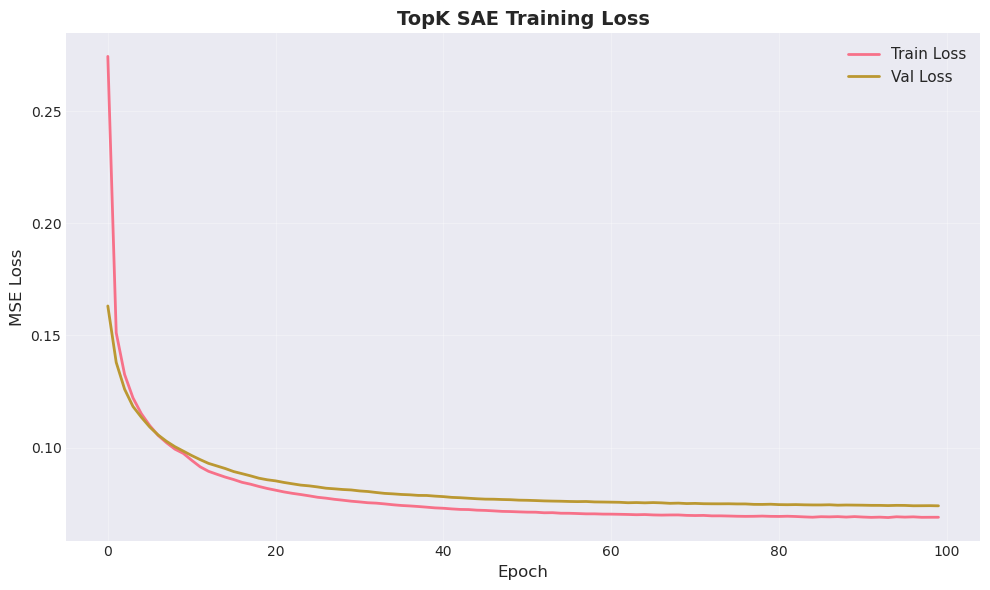

Final train loss: 0.068891
Final val loss: 0.073992


In [43]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('TopK SAE Training Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final val loss: {val_losses[-1]:.6f}")

## Feature Extraction: Get Sparse Hidden Activations


In [45]:
# Extract sparse hidden activations for all data
model.eval()
all_features = []

# Process in batches to avoid memory issues
batch_size_extract = 256
all_latents = torch.FloatTensor(latents_normalized).to(device)

with torch.no_grad():
    for i in range(0, len(all_latents), batch_size_extract):
        batch_x = all_latents[i:i+batch_size_extract]
        # Use get_acts which returns sparse latent activations (already top-k applied)
        features = model.get_acts(batch_x)  # [batch_size, 120]
        all_features.append(features.cpu().numpy())

# Concatenate all features
all_features = np.concatenate(all_features, axis=0)
print(f"Extracted features shape: {all_features.shape}")
print(f"Feature sparsity: {(all_features == 0).sum() / all_features.size * 100:.1f}%")
print(f"Average active features per sample: {(all_features != 0).sum(axis=1).mean():.2f} (expected: {model.k})")


Extracted features shape: (16493, 120)
Feature sparsity: 95.0%
Average active features per sample: 6.00 (expected: 6)


## Feature Analysis: Correlations with RMSD


In [46]:
# Calculate Spearman correlations between each feature and RMSD
feature_correlations = []
feature_pvalues = []

for feat_idx in range(all_features.shape[1]):
    corr, pval = spearmanr(all_features[:, feat_idx], rmsd)
    feature_correlations.append(corr)
    feature_pvalues.append(pval)

feature_correlations = np.array(feature_correlations)
feature_pvalues = np.array(feature_pvalues)

# Sort features by absolute correlation
sorted_indices = np.argsort(np.abs(feature_correlations))[::-1]

print("Top 10 features by absolute correlation with RMSD:")
print("Feature | Correlation | P-value")
print("-" * 40)
for i in range(min(10, len(sorted_indices))):
    idx = sorted_indices[i]
    print(f"  {idx:3d}   |  {feature_correlations[idx]:+7.4f}   | {feature_pvalues[idx]:.2e}")

# Features with significant correlations (p < 0.05)
significant_features = np.where(feature_pvalues < 0.05)[0]
print(f"\nSignificant features (p < 0.05): {len(significant_features)} out of {all_features.shape[1]}")


Top 10 features by absolute correlation with RMSD:
Feature | Correlation | P-value
----------------------------------------
   12   |  +0.3716   | 0.00e+00
   24   |  -0.3359   | 0.00e+00
   16   |  -0.3336   | 0.00e+00
  112   |  +0.3208   | 0.00e+00
    9   |  +0.2604   | 9.12e-254
   22   |  +0.2370   | 2.66e-209
  119   |  -0.2238   | 3.19e-186
   11   |  +0.2205   | 8.30e-181
   59   |  -0.2179   | 2.11e-176
   35   |  +0.2129   | 1.98e-168

Significant features (p < 0.05): 113 out of 120


## Visualizations: Feature Activation Heatmap


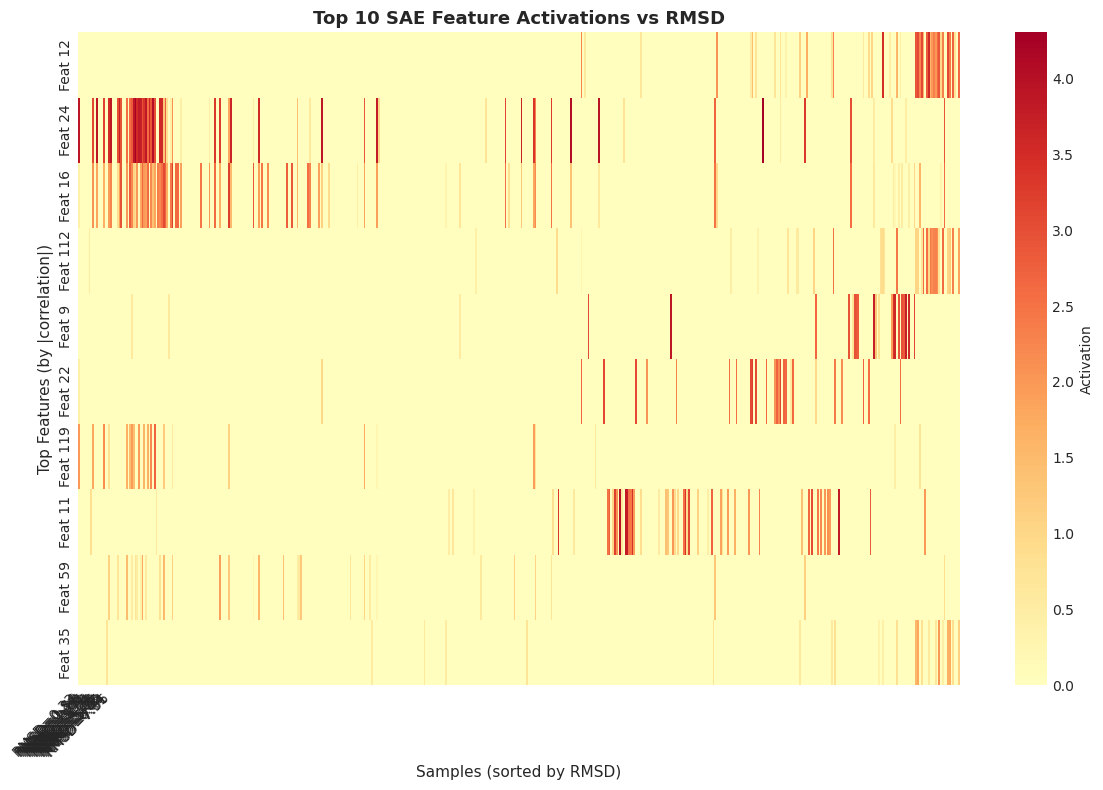

In [47]:
# Feature activation heatmap: top 10 features, sorted by RMSD
top_n_features = 10
top_feature_indices = sorted_indices[:top_n_features]

# Sort samples by RMSD
sorted_by_rmsd = np.argsort(rmsd)
n_samples_plot = min(500, len(rmsd))  # Plot up to 500 samples for clarity
sample_indices = sorted_by_rmsd[::max(1, len(rmsd)//n_samples_plot)][:n_samples_plot]

# Extract feature activations for top features and selected samples
heatmap_data = all_features[np.ix_(sample_indices, top_feature_indices)]

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, 
            xticklabels=[f"RMSD={rmsd[i]:.2f}" for i in sample_indices[::max(1, len(sample_indices)//20)]],
            yticklabels=[f"Feat {idx}" for idx in top_feature_indices],
            cmap='RdYlBu_r', center=0,
            cbar_kws={'label': 'Activation'})
plt.xlabel('Samples (sorted by RMSD)', fontsize=11)
plt.ylabel('Top Features (by |correlation|)', fontsize=11)
plt.title('Top 10 SAE Feature Activations vs RMSD', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Visualizations: Scatter Plots of Top 3 Features vs RMSD


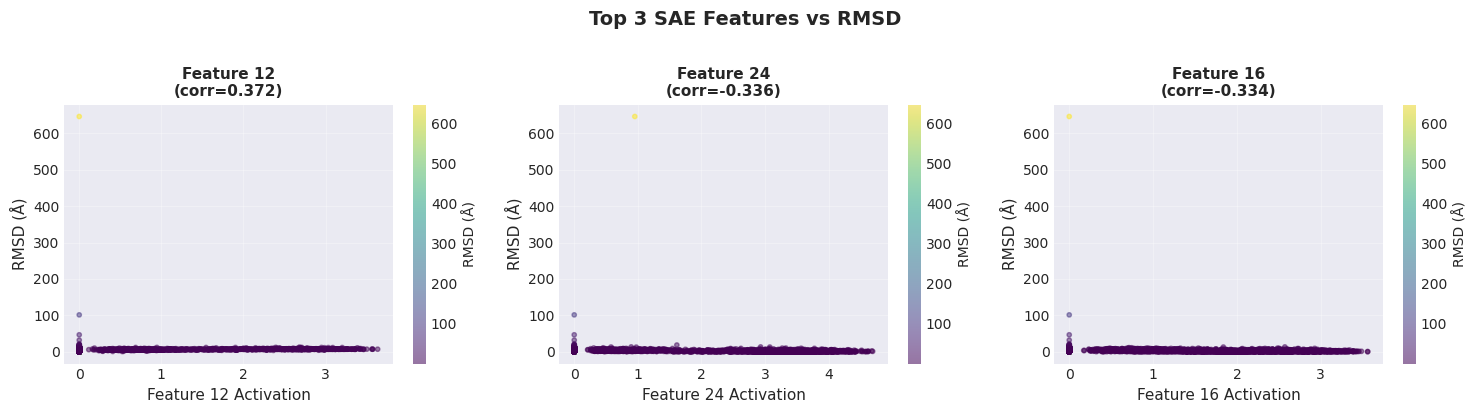

In [48]:
# Scatter plots of top 3 features vs RMSD
top_3_features = sorted_indices[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feat_idx in enumerate(top_3_features):
    ax = axes[i]
    scatter = ax.scatter(all_features[:, feat_idx], rmsd, 
                        c=rmsd, cmap='viridis', alpha=0.5, s=10)
    ax.set_xlabel(f'Feature {feat_idx} Activation', fontsize=11)
    ax.set_ylabel('RMSD (Å)', fontsize=11)
    ax.set_title(f'Feature {feat_idx}\n(corr={feature_correlations[feat_idx]:.3f})', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='RMSD (Å)')

plt.suptitle('Top 3 SAE Features vs RMSD', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Baseline Classifier: Logistic Regression on SAE Features


In [49]:
# Train logistic regression on SAE features
# Binary classification: RMSD < 2Å (good) vs RMSD >= 2Å (poor)

# Prepare data
is_good_pose = (rmsd < 2.0).astype(int)

# Split features into train/val (same split as SAE training)
X_train_features = all_features[:len(X_train)]
X_val_features = all_features[len(X_train):len(X_train)+len(X_val)]
y_train_binary = is_good_pose[:len(X_train)]
y_val_binary = is_good_pose[len(X_train):len(X_train)+len(X_val)]

print(f"Training logistic regression on SAE features...")
print(f"Train: {len(X_train_features)} samples, {y_train_binary.sum()} good poses")
print(f"Val: {len(X_val_features)} samples, {y_val_binary.sum()} good poses")

# Train logistic regression
lr_sae = LogisticRegression(max_iter=1000, random_state=42)
lr_sae.fit(X_train_features, y_train_binary)

# Predictions
y_train_pred_sae = lr_sae.predict_proba(X_train_features)[:, 1]
y_val_pred_sae = lr_sae.predict_proba(X_val_features)[:, 1]

# Calculate auPR
train_aupr_sae = average_precision_score(y_train_binary, y_train_pred_sae)
val_aupr_sae = average_precision_score(y_val_binary, y_val_pred_sae)

print(f"\nSAE Features Classifier:")
print(f"  Train auPR: {train_aupr_sae:.4f}")
print(f"  Val auPR: {val_aupr_sae:.4f}")


Training logistic regression on SAE features...
Train: 11545 samples, 1921 good poses
Val: 4948 samples, 507 good poses

SAE Features Classifier:
  Train auPR: 0.8146
  Val auPR: 0.1349


## Baseline Comparison: Logistic Regression on Raw Latent Vectors


In [50]:
# Train logistic regression on raw 30D latent vectors (no SAE) for comparison
X_train_raw = latents_normalized[:len(X_train)]
X_val_raw = latents_normalized[len(X_train):len(X_train)+len(X_val)]

print(f"Training logistic regression on raw latent vectors...")
print(f"Train: {len(X_train_raw)} samples")
print(f"Val: {len(X_val_raw)} samples")

# Train logistic regression
lr_raw = LogisticRegression(max_iter=1000, random_state=42)
lr_raw.fit(X_train_raw, y_train_binary)

# Predictions
y_train_pred_raw = lr_raw.predict_proba(X_train_raw)[:, 1]
y_val_pred_raw = lr_raw.predict_proba(X_val_raw)[:, 1]

# Calculate auPR
train_aupr_raw = average_precision_score(y_train_binary, y_train_pred_raw)
val_aupr_raw = average_precision_score(y_val_binary, y_val_pred_raw)

print(f"\nRaw Latent Vectors Classifier:")
print(f"  Train auPR: {train_aupr_raw:.4f}")
print(f"  Val auPR: {val_aupr_raw:.4f}")


Training logistic regression on raw latent vectors...
Train: 11545 samples
Val: 4948 samples

Raw Latent Vectors Classifier:
  Train auPR: 0.7019
  Val auPR: 0.1160


## Results Summary


In [51]:
# Print comprehensive results summary
print("=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)

print(f"\n1. MODEL ARCHITECTURE:")
print(f"   - Input dimension: 30D")
print(f"   - Hidden dimension: 120D")
print(f"   - TopK sparsity: K={model.k} ({model.k/model.hidden_dim*100:.1f}% active)")
print(f"   - Final train loss: {train_losses[-1]:.6f}")
print(f"   - Final val loss: {val_losses[-1]:.6f}")

print(f"\n2. TOP CORRELATED FEATURES WITH RMSD:")
print(f"   (Features with highest |Spearman correlation|)")
for i in range(min(10, len(sorted_indices))):
    idx = sorted_indices[i]
    sig = "*" if feature_pvalues[idx] < 0.05 else " "
    print(f"   {sig} Feature {idx:3d}: corr = {feature_correlations[idx]:+7.4f}, p = {feature_pvalues[idx]:.2e}")

print(f"\n3. CLASSIFICATION PERFORMANCE (auPR):")
print(f"   Raw 30D Latent Vectors:")
print(f"     Train auPR: {train_aupr_raw:.4f}")
print(f"     Val auPR:   {val_aupr_raw:.4f}")
print(f"   SAE Features (120D, TopK={model.k}):")
print(f"     Train auPR: {train_aupr_sae:.4f}")
print(f"     Val auPR:   {val_aupr_sae:.4f}")
print(f"   Improvement: {val_aupr_sae - val_aupr_raw:+.4f} ({((val_aupr_sae/val_aupr_raw - 1)*100):+.1f}%)")

print(f"\n4. DATA STATISTICS:")
print(f"   Total samples: {len(latents)}")
print(f"   Good poses (RMSD < 2Å): {(rmsd < 2.0).sum()} ({(rmsd < 2.0).mean()*100:.1f}%)")
print(f"   Poor poses (RMSD >= 2Å): {(rmsd >= 2.0).sum()} ({(rmsd >= 2.0).mean()*100:.1f}%)")
print(f"   RMSD range: {rmsd.min():.2f} - {rmsd.max():.2f} Å")

print("\n" + "=" * 60)


RESULTS SUMMARY

1. MODEL ARCHITECTURE:
   - Input dimension: 30D
   - Hidden dimension: 120D
   - TopK sparsity: K=6 (5.0% active)
   - Final train loss: 0.068891
   - Final val loss: 0.073992

2. TOP CORRELATED FEATURES WITH RMSD:
   (Features with highest |Spearman correlation|)
   * Feature  12: corr = +0.3716, p = 0.00e+00
   * Feature  24: corr = -0.3359, p = 0.00e+00
   * Feature  16: corr = -0.3336, p = 0.00e+00
   * Feature 112: corr = +0.3208, p = 0.00e+00
   * Feature   9: corr = +0.2604, p = 9.12e-254
   * Feature  22: corr = +0.2370, p = 2.66e-209
   * Feature 119: corr = -0.2238, p = 3.19e-186
   * Feature  11: corr = +0.2205, p = 8.30e-181
   * Feature  59: corr = -0.2179, p = 2.11e-176
   * Feature  35: corr = +0.2129, p = 1.98e-168

3. CLASSIFICATION PERFORMANCE (auPR):
   Raw 30D Latent Vectors:
     Train auPR: 0.7019
     Val auPR:   0.1160
   SAE Features (120D, TopK=6):
     Train auPR: 0.8146
     Val auPR:   0.1349
   Improvement: +0.0189 (+16.3%)

4. DATA STATI